In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import KFold

Define parameters for the model

In [2]:
# Parameters
wght_decay, p_drop, learn_rate = 0.0005, 0.05, 5e-7
train_data_ratio, nb_units, nb_epochs = 0.8, 10, 300

Define functions to normalize and de-normalize the data

In [3]:
def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

Define the function that extracts the data

In [4]:
def measurements_and_training_data(num_parts=25, ratio_=1.0):
    """
    num_parts: is the number of parts to be analyzed, ratio_: is the ratio of the data to be used as training
    This function load the dataset for the bond length of each part (1 to num_parts)
    """
    # =================================================================================================================== %
    # _______________________________________________       INPUTS     ___________________________________________________
    # =================================================================================================================== %
    wth = 0.8  # width of filaments [m]

    # =================================================================================================================== %
    # ___________________________________        IMPORT Measured BOND LENGTH DATA     ____________________________________
    # =================================================================================================================== %
    # Directory where measurements are stored
    dir_measurements = "C:/Users/berkc/Box Sync/AM/SecondPaperMultiObjective/ModelCalibration/ManufacturedParts_BL"

    # total number of sets
    total_sets = 3

    # IMPORT Measured BOND LENGTH DATA
    start_part_id = 1  # starting ID part

    total_parts = np.arange(start_part_id, num_parts + 1, dtype='int32')
    index_to_remove = [13, 20]  # remove parts that do not have measurements, i.e., 5,14,21
    total_parts = np.delete(total_parts, index_to_remove)  # remove elements

    ctr = 0  # counter of parts
    measured_bl_row = []  # list stores bond length (BL) data of all parts
    inp = []              # list storing training data inputs

    measured_bl_sets = [] # list of BL sets

    for set_id in range(1, total_sets+1):    # loop over each part set
        measured_bl_eachSet = []
        for part_id in total_parts:  # loop over each manufactured part ID

            # Read Process parameters & bond length measurements
            bl_file = dir_measurements + "/Round" + str(set_id) + "/PPSet" + str(part_id) + ".xlsx"

            df = pd.read_excel(bl_file, header=None)  # read the excel file

            num_layers = df.iloc[2, 0]  # # of layers
            num_interfaces = df.iloc[-2, 1]  # # of interfaces/layer
            num_interfaces_of_a_part = int(num_layers * num_interfaces)  # num. of interfaces of that part

            # save printer temperature, speed, height input for each part
            t_n = df.iloc[0, 1]  # Printer nozzle temperature(ยบC)
            v_p = df.iloc[0, 3]  # printer speed mm / s
            hth = df.iloc[0, 5]  # layer height[mm]
            t_n = float(t_n)
            v_p = float(v_p)

            # print('T_N, v_p, height:', t_n, v_p, hth, "\n")

            raw_measuredbl = df.iloc[2:-1, 3]  # measured bond lengths between each interface
            raw_measuredbl = raw_measuredbl.astype('float32')

            # reshape the measured bond length array & convert to numpy ndarray
            reshaped_measured_bl = raw_measuredbl.values.reshape(num_interfaces, num_layers, order='F').copy()

            # first column is 1st layer and soon(each row is each interface bond length, BL)
            measured_bl = np.fliplr(reshaped_measured_bl).T  # flip matrix left to right

            # store measured BL data of all parts in order reshaped in row
            measured_bl_row.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])
            measured_bl_eachSet.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])

            # if part_id==5:
            #     print(measured_bl.T)

            # Prediction inputs are x & y coordinates of vertical bond length locations
            # x, y coordinate of layer 1 & interface 1(vertical)
            ycoord = 0.5 * hth  # 0.5*height of a layer in mm
            iki_y = ycoord * 2

            # store inputs for GP(model disrepancy at each interface)
            for jj in range(1,num_layers+1):
                for ii in range(1,num_interfaces+1):
                    # use x & y coordinates of vertical bonds as training data for the GP
                    # Inp =[ Temperature, speed, height, x, y ]
                    inp.append([t_n, v_p, hth, ii * wth, ycoord + (jj - 1) * iki_y])

            ctr += 1  # increment counter to keep track of total number of parts analyzed

        # to save 3 sets of data on 3 columns to analyze mean and std of data for aleatoric
        measured_bl_sets.append(measured_bl_eachSet)
    measured_bl_set1 = np.concatenate(measured_bl_sets[0], axis=1)
    measured_bl_set1 = measured_bl_set1.T  # transpose s.t. the number of rows matches Inp
    measured_bl_set2 = np.concatenate(measured_bl_sets[1], axis=1)
    measured_bl_set2 = measured_bl_set2.T  # transpose s.t. the number of rows matches Inp
    measured_bl_set3 = np.concatenate(measured_bl_sets[2], axis=1)
    measured_bl_set3 = measured_bl_set3.T  # transpose s.t. the number of rows matches Inp
    measured_bl_setsAll = np.hstack((measured_bl_set1,measured_bl_set2,measured_bl_set3))

    # Inp: stored inputs for Gaussian process
    # (model disrepancy at each interface): [T_N, v_p, hth, x, y]
    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')

    # concatenating different size arrays stored in a list
    measured_bl_row = np.concatenate(measured_bl_row, axis=1)
    measured_bl_row = measured_bl_row.T  # transpose s.t. the number of rows matches Inp

    # Normalize training data
    # inp = (inp - inp.mean(axis=0)) / inp.std(axis=0)  # take mean of each column
    # measured_bl_row = (measured_bl_row - measured_bl_row.mean(axis=0)) / measured_bl_row.std(axis=0)  # take mean of each column

    alldata = np.hstack((inp, measured_bl_row))  # stack 2 numpy arrays column-wise

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = inp.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_ * nl)
    idx_ = np.random.permutation(nl)
    # idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]
    # all_data_train = alldata[idx_train, :]

    # mean_of_data = all_data_train.mean(axis=0)
    # std_of_data = all_data_train.std(axis=0)
    # all_data_train = (all_data_train - mean_of_data) / std_of_data  # take mean of each column


    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    x_test = alldata[idx_test, :-1]
    y_test = alldata[idx_test, -1]

    return alldata, x_test, y_test, measured_bl_setsAll

Load the data by calling the function we defined above:

In [5]:
# load training and test data
train_data, x_tst, y_tst, BL_sets = measurements_and_training_data()

x = train_data[:, :-1]  # training data, for all but last column
y = train_data[:, -1]  # measurements of the training data, last column

# Replace the values of  bond length (BL) that are less than 0.1 with 0.
# The reason for this is that the BL values were supposed to be zero,
# for those interfaces but not recorded so.
y[y<0.1] = 0

# save max and min values of x and y
max_x = x.max(axis=0)
min_x = x.min(axis=0)
max_y = y.max(axis=0)
min_y = y.min(axis=0)

# normalize data
x = normalize_max_min(x, max_x, min_x)
y = normalize_max_min(y, max_y, min_y)

# stack input and output data
train_data = np.column_stack((x,y))
batch_size = train_data.shape[0]

Define functions and classes for the BNN:

In [6]:
def to_variable(var=(), cuda=False, volatile=False):
    out = []
    for v in var:

        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        # if not v.is_cuda and cuda:
        #     v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5 * (target - output) ** 2 / sigma ** 2
    log_coeff = -no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
    return - (log_coeff + exponent).sum()



class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        # self.layer3 = nn.Linear(num_units, num_units)
        # self.layer4 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer3(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer4(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x


class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        self.learn_rate = learn_rate
        self.batch_size = batch_size

        self.network = network
        # self.network.cuda()

        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        # self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)

        # reset gradient and total loss
        self.optimizer.zero_grad()

        output = self.network(x)

        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        loss.backward()
        self.optimizer.step()

        return loss

    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)

        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())

        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1) ** 2) ** 0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)

        rmse = ((mean - y) ** 2).mean() ** 0.5

        return loss.detach().cpu(), rmse.detach().cpu()


Define the function that fits the BNN and shuffles the data and use some for testing.

In [7]:
def train_mc_dropout(data, drop_prob, ratio_train_data, num_epochs, num_units, learn_rate, weight_decay, log_every,
                     num_samples):

    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = data.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_train_data * nl)
    idx_ = np.random.permutation(nl)
    # idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]

    x_train, y_train = data[idx_train, :in_dim], data[idx_train, in_dim:]

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    x_test, y_test = data[idx_test, :in_dim], data[idx_test, in_dim:]

    y_means, y_stds = y_train.mean(axis=0), y_train.var(axis=0) ** 0.5

    net = MC_Dropout_Wrapper(
            network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
            learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    for i in range(num_epochs):

        loss = net.fit(x_train, y_train)

        tt, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        rmse_train = rmse_train.cpu().data.numpy()

        test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

        history_loss.append(loss.cpu().data.numpy() / len(x_train))
        history_loss_test.append(test_loss / len(x_test))
        history_rmse.append(rmse_train )
        history_rmse_test.append(rmse_test )

        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f' %
                    (i, loss.cpu().data.numpy() / len(x_train), test_loss / len(x_test), rmse ))

    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

    train_logliks.append((train_loss.cpu().data.numpy() / len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy() / len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(train_rmse.cpu().data.numpy())
    test_rmses.append(test_rmse.cpu().data.numpy())

    plt.figure()
    # plot history of accuracy
    # Plot training & validation accuracy values
    plt.plot(history_rmse)
    plt.plot(history_rmse_test)
    plt.title('Model accuracy')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.figure()
    # Plot training & validation loss values
    plt.plot(history_loss)
    plt.plot(history_loss_test)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test

Call the function to build the network

Epoch:    0, Train loss:  1.197 Test loss:  1.190 RMSE: 0.782
Epoch:  100, Train loss:  0.755 Test loss:  0.751 RMSE: 0.390
Epoch:  200, Train loss:  0.335 Test loss:  0.332 RMSE: 0.169
Epoch:  299, Train loss: -0.055 Test loss: -0.058 RMSE: 0.138


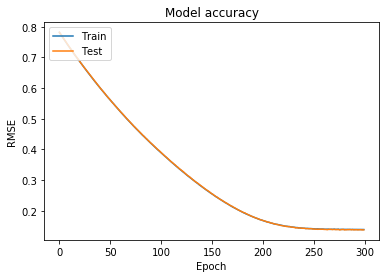

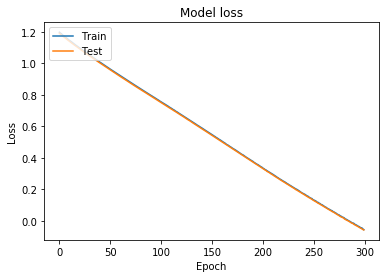

Train log. lik. =  2.017 +/-  0.000
Test  log. lik. =  2.020 +/-  0.000
Train RMSE      =  0.139 +/-  0.000
Test  RMSE      =  0.137 +/-  0.000


In [8]:
net, x_tst, y_tst = train_mc_dropout(data=train_data, drop_prob=p_drop, num_epochs=nb_epochs, 
                                     ratio_train_data=train_data_ratio, num_units=nb_units, learn_rate=learn_rate, 
                                     weight_decay=wght_decay, num_samples=10, log_every=100)

Test the model using the unique temperature values of the test data and plot the predictions with both epistemic and aleatoric uncertainty. The epistemic uncertainty is obtained by running the BNN (MC dropout) several times.

In [9]:
# Get a tuple of unique values & their first index location from a numpy array
uniqueValues, indicesList = np.unique(x_tst[:,0], return_index=True)
x_tst = x_tst[indicesList]

# Only use the selected unique test data
y_tst = y_tst[indicesList]

x_pred = torch.tensor(x_tst.astype(np.float32)) # convert to torch tensor

samples = []
noises = []
for i in range(100):
    preds = net.network.forward(x_pred).cpu().data.numpy()
    samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
    noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

samples = np.array(samples)
noises = np.array(noises)
means = (samples.mean(axis=0)).reshape(-1)

aleatoric = (noises ** 2).mean(axis=0) ** 0.5
epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

print("Aleatoric uncertainty mean: {0:.4f}, Epistemic uncertainty mean: {1:.4f}, Total uncertainty mean: {2:.4f}"
      .format(aleatoric.mean(), epistemic.mean(), total_unc.mean()))
print("Aleatoric uncertainty std: {0:.4f}, Epistemic uncertainty std: {1:.4f}, Total uncertainty std: {2:.4f}"
      .format(aleatoric.std(), epistemic.std(), total_unc.std()))

Aleatoric uncertainty mean: 0.2531, Epistemic uncertainty mean: 0.0417, Total uncertainty mean: 0.2566
Aleatoric uncertainty std: 0.0053, Epistemic uncertainty std: 0.0057, Total uncertainty std: 0.0053


Plot predictions with predictive mean and variance

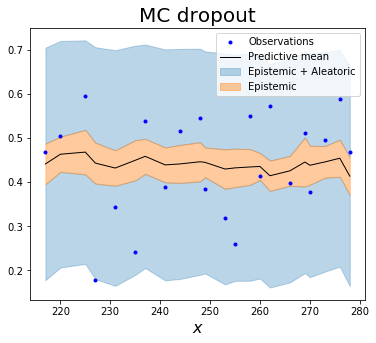

In [10]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# denormalize test data
x_tst = denormalize_max_min(x_tst, max_x, min_x)
y_tst = denormalize_max_min(y_tst, max_y, min_y)


# PLOT FIGURES
plt.figure(figsize=(6, 5))
plt.style.use('default')
plt.plot(x_tst[:,0], y_tst, 'b.', label='Observations');
plt.fill_between(x_tst[:,0], means + epistemic, means + total_unc, color=c[0], alpha=0.3,
                 label='Epistemic + Aleatoric')
plt.fill_between(x_tst[:,0], means - total_unc, means - epistemic, color=c[0], alpha=0.3)
plt.fill_between(x_tst[:,0], means - epistemic, means + epistemic, color=c[1], alpha=0.4,
                 label='Epistemic')
plt.plot(x_tst[:,0], means, color='black', linewidth=1, label='Predictive mean')
plt.xlabel('$x$', fontsize=16)
plt.title('MC dropout', fontsize=20)
plt.legend()
plt.show()